<a href="https://colab.research.google.com/github/marktfaust/Variational-Autoencoder-Image-Generation/blob/main/Mark_Faust_DL_homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #5: Generating Images with a Variational Autoencoder (VAE)
## 31 Total Points



In this homework, we will again use the MNIST dataset of hand-written digits.  We will train a [variational autoencoder](https://en.wikipedia.org/wiki/Variational_autoencoder), a kind of [deep generative model](https://www.youtube.com/watch?v=XZ0PMRWXBEU), on this data.  You'll implement the code that defines the VAE class along with its functionality for forward computation and sampling.  Leave the training hyperparameters are their default configurations, as this represents a good balance between a clearly working implementation and reasonable computational overhead.

Let's start by importing the usual libraries....

In [1]:
# For plotting
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# PyTorch data utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Load MNIST Data

The MNIST dataset consists of handwritten digits as 28x28 grayscale images, normalized to [0, 1].

In [2]:
# -----------------------------
# Load MNIST
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's visualize a few images...

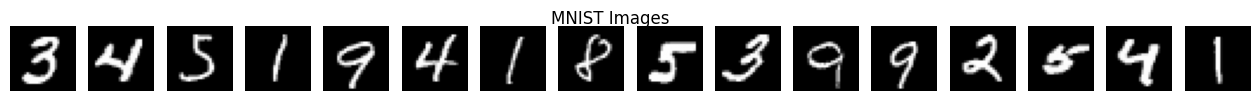

In [3]:
# Visualize MNIST samples
examples = next(iter(dataloader))[0][:16]
fig, axes = plt.subplots(1, 16, figsize=(16, 1))
for i in range(16):
    axes[i].imshow(examples[i, 0], cmap='gray')
    axes[i].axis('off')
plt.suptitle("MNIST Images")
plt.show()

## Encoder and Decoder  (12 Points)

The first step is to implement the encoder and decoder.

**Encoder:**
We will treat the image as a flat vector of $D_x = 28*28 = 784$ dimensions.  You should implement this flattening operation yourself.  The encoder should then use a one-hidden-layer feedforward network to map the flattened input $\mathbf{x} \in \mathbb{R}^{D_x}$ into a latent Normal distribution, outputting both the mean, $\mathbf{\mu} \in \mathbb{R}^{D_z} $, and log of the standard deviation $\log \mathbf{\sigma} \in \mathbb{R}^{D_z}$, where $D_z$ is the user-specified dimensionality:
$$
\mathbf{h} = \text{ReLU}(W_1 \mathbf{x} + b_1), \quad
\boldsymbol{\mu} = W_\mu \mathbf{h} + b_\mu, \quad  \log \boldsymbol{\sigma} = W_{\log\sigma} \mathbf{h} + b_{\log\sigma}
$$

These parameters define the approximate posterior for the local latent variable: $$q(\mathbf{z}|\mathbf{x}) = \prod_{d=1}^{D_z} N\left(z_d; \mu_d, \sigma_d \right).$$


In [4]:
class Encoder(nn.Module):
    """
    Encoder network for VAE. Takes in a batch of images and outputs mean and log-variance vectors.

    Args:
        latent_dim (int): Dimension of the latent space.
    """
    def __init__(self, latent_dim, input_dim = 784, hid_dim = 400):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        ### YOUR SOLUTION GOES HERE ###  (3 Points)
        # Define the necessary fully-connected transformations
        ###############################
        # flatten/input layer to bring image to 1 x 784
        self.flatten = nn.Flatten()
        # hidden layer
        self.fc1 = nn.Linear(input_dim, hid_dim)
        # mu output layer
        self.fc_mu = nn.Linear(hid_dim, latent_dim)
        # log_std output layer
        self.fc_log_std = nn.Linear(hid_dim, latent_dim)

    def forward(self, x):
        """
        Forward pass of the encoder.

        Inputs:
          x (Tensor): Input batch of shape (batch_size, 1, 28, 28)
        Returns:
          mu (Tensor): Mean vector of shape (batch_size, latent_dim)
          log_std (Tensor): Log-standard-deviation vector of shape (batch_size, latent_dim)
        """
        ### YOUR SOLUTION GOES HERE ### ( 4 Points)
        # Define the forward computation to compute the mean and log std.
        # flatten image x
        x = self.flatten(x)
        # calculate hidden activation
        h = F.relu(self.fc1(x))
        # get mu
        mu = self.fc_mu(h)
        # get log_std
        log_std = self.fc_log_std(h)
        return (mu, log_std)
        ###############################

Now let's implement the decoder.

**Decoder:** Takes the latent vector $ \mathbf{z} $ as input and maps it back to image space via one hidden layer and logistic (sigmoid) output transformation:
$$
\mathbf{h'} = \text{ReLU}(W_2 \mathbf{z} + b_2), \quad \mathbb{E}\left[ \mathbf{x} | \mathbf{z} \right] = \text{sigmoid}(W_{\text{out}} \mathbf{h'} + b_{\text{out}}).
$$  Before returning $\mathbb{E}\left[ \mathbf{x} | \mathbf{z} \right]$, be sure to re-size it from a vector to being a square matrix (28x28).

In [5]:
class Decoder(nn.Module):
    """
    Decoder network for VAE. Takes latent vectors and returns expected value of reconstructed image, E[X | Z].

    Args:
        latent_dim (int): Dimension of the latent space.
    """
    def __init__(self, latent_dim, hid_dim = 400, output_dim = 784):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        ### YOUR SOLUTION GOES HERE ###  (2 Points)
        # Define the necessary fully-connected transformations
        ###############################
        # first decoder layer (hidden)
        self.fc2 = nn.Linear(latent_dim, hid_dim)
        # dimension-correcting layer
        self.fc_out = nn.Linear(hid_dim, output_dim)
        # unflattening/output layer
        self.unflatten = nn.Unflatten(1, (1, 28, 28))


    def forward(self, z):
        """
        Forward pass of the decoder.

        Inputs:
          z (Tensor): Latent vector of shape (batch_size, latent_dim)
        Returns:
          x_recon (Tensor): Expected value of reconstructed image of shape (batch_size, 1, 28, 28)
        """
        ### YOUR SOLUTION GOES HERE ###  (3 Points)
        # Define the forward computation to compute E[X | Z]
        # calculate hidden activation
        h_p = F.relu(self.fc2(z))
        # transform back into 1 x 784
        x_logits = self.fc_out(h_p)
        # get class probabilities
        x_recon_flat = F.sigmoid(x_logits)
        # unflatten to return image 1 x 28 x 28
        x_recon = self.unflatten(x_recon_flat)
        return x_recon
        ###############################

## Variational Autoencoder  (14 Points)

Given our encoder and decoder implementations above, we can now use them to define our variational autoencoder class.  Specifically, the VAE computation is as follows.  First we use the encoder to compute the mean and log standard deviation.
$$ \left\{ \mathbf{\mu}, \ \log \mathbf{\sigma} \right\} \ = \ \text{Encoder}(\mathbf{x}). $$

We then use the [reparameterization trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/) to compute the sample from the latent Normal distribution in a way that is ammendable to taking derivatives through it:
$$ \mathbf{\hat{z}} \ = \ \mathbf{\mu} + \exp\left\{ \log \mathbf{\sigma} \right\} \odot \boldsymbol{\epsilon}, \ \ \ \boldsymbol{\epsilon} \in \mathbb{R}^{D_z}, \ \ \ \epsilon_d \sim N(0,1)$$ where $\boldsymbol{\epsilon} \in \mathbb{R}^{D_z}$ is a $D_z$-dimensional sample from a standard normal distribution.  You may have seen this equation before as the normal distribution's [location-scale form](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family).  This is also an application of the fact that the the space of [Normal distribution is closed under affine transformations](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Affine_transformation).

Lastly, we use the decoder to compute the expected value of the observed variable $\mathbf{x}$ given the latent variable $\mathbf{z}$:
$$ \mathbb{E}\left[\mathbf{x} | \mathbf{\hat{z}}\right] \ = \ \text{Decoder}\left( \mathbf{\hat{z}} \right).$$

After training, we will want to sample novel instances (in this case, images) from the VAE.  We can do this by passing in samples from a $D_z$-dimensional standard normal distribution directly into the decoder.  The decoder then outputs the mean of a Bernoulli distribution, which we then use to sample the final pixel values:
$$ \mathbf{\hat{z}} \ \sim \ N(0, \mathbf{I}), \quad \quad \mathbf{\pi} \  = \ \mathbb{E}\left[\mathbf{x} | \mathbf{\hat{z}}\right] \ =  \  \text{Decoder}(\mathbf{\hat{z}}), \quad \quad \mathbf{\hat{x}} \ \sim \ \text{Bernoulli}(\mathbf{\pi}). $$  Ideally, if our training went well, $\mathbf{\hat{x}}$ should look like an instance of the dataset of images on which we trained the data.

In [6]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class that combines the encoder, decoder, and reparameterization.

    Args:
        latent_dim (int): Dimension of the latent space.
    """
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        ### YOUR SOLUTION GOES HERE ###  (2 Points)
        # define the encoder and decoder
        ###############################
        # define encoder
        self.encoder = Encoder(latent_dim)
        # define decoder
        self.decoder = Decoder(latent_dim)


    def reparameterize(self, mu, log_std):
        """
        Applies the reparameterization trick to sample from N(mu, sigma).

        Inputs:
            mu (Tensor): Mean of the latent distribution.
            log_std (Tensor): Log standard deviation of the latent distribution.

        Returns:
            Tensor: Sampled latent vector.
        """
        ### YOUR SOLUTION GOES HERE ###  (3 Points)
        # Implement the reparameterization trick for computing a sample of z ~ q(z | x)
        z = mu + torch.exp(log_std) * torch.randn(self.latent_dim)
        return z
        ###############################


    def forward(self, x):
        """
        Forward pass of the VAE.

        Inputs:
            x (Tensor): Input
            image batch of shape (batch_size, 1, 28, 28)

        Returns:
            x_recon (Tensor): Reconstructed images
            mu (Tensor): Mean latent vectors
            log_std (Tensor): Log-standard-deviation of latent vectors
        """
        ### YOUR SOLUTION GOES HERE ###  (3 Points)
        # Implement the forward computation to return E[X|Z] and the parameters of the latent distribution
        # retrieve mu and log_std
        (mu, log_std) = self.encoder(x)
        z = self.reparameterize(mu, log_std)
        x_recon = self.decoder(z)
        return (x_recon, mu, log_std)
        ###############################


    def sample(self, num_samples):
        """
        Generates samples from the VAE.

        Inputs:
            num_samples (int): Number of samples to generate.

        Returns:
            Tensor: Sampled images of shape (num_samples, 1, 28, 28).
        """
        ### YOUR SOLUTION GOES HERE ###  (3 Points)
        # Sample z ~ N(0,1), pass it through the decoder, sample from Bernoulli
        z = torch.randn(num_samples, self.latent_dim)
        x_probs = self.decoder(z)
        x_recon = torch.bernoulli(x_probs)
        return x_recon
        ###############################

Now we move on to computing the VAE's loss function, which is an implementation of the [evidence lower bound](https://en.wikipedia.org/wiki/Evidence_lower_bound).  It consists of two terms.  The first is the reconstruction loss, where we compute how well $\mathbb{E}[\mathbf{x} | \mathbf{z}]$ matches the observed value $\mathbf{x}_n$.
$$
-\mathbb{E}_{q(\mathbf{z}|\mathbf{x}_n]}\left[\log p(\mathbf{x}_n|\mathbf{z})\right] \approx \frac{1}{S} \sum_{s=1}^{S} -\log \text{Bernoulli}\left(\mathbf{x}_n; \boldsymbol{\pi} = \text{Decoder}\left( \mathbf{\hat{z}_s} \right) \right) $$ $$ = \ \frac{1}{S} \sum_{s=1}^{S} \sum_{d=1}^{D_x} -\log \text{Bernoulli}\left(x_{n,d}; \pi_d = \text{Decoder}_d\left( \mathbf{\hat{z}} \right) \right).$$ where $\text{Decoder}_d\left( \mathbf{\hat{z}} \right)$ denotes the $d$-th dimension of the decoder's output and $S$ is the number of times we sample the latent variable for the Monte Carlo approximation.  In practice, we use just one sample ($S=1$), and therefore the reconstruction loss becomes:
$$ = \sum_{d=1}^{D_x} - x_{n,d} \log \left\{ \text{Decoder}_d\left( \mathbf{\hat{z}} \right) \right\} - (1-x_{n,d}) \log \left\{ 1 - \text{Decoder}_d\left( \mathbf{\hat{z}} \right) \right\}. $$


The second term is a regularization term that keeps the distributions output by the encoder close to some prior, which we will assume is $N(\mathbf{0}, \mathbf{I})$.  Using a normal distribution as both the prior and the posterior allows us to write an exact formula for the KL divergence ([here's the derivation](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)), which simplifies to:
$$
\mathbb{KL}\left[ N(\boldsymbol{\mu}, \text{diag}(\boldsymbol{\sigma}^2)) \ \| \  N(0, \mathbf{I}) \right]
\ = \ \sum_{d=1}^{D_z} \frac{1}{2}\left( \sigma_{d}^{2} + \mu_{d}^{2} \right) - \log \sigma_d - \frac{1}{2}.
$$

Putting both terms together, we have the final loss function:
$$
\sum_{n=1}^{N} \sum_{d=1}^{D_x} - x_{n,d} \log \left\{ \text{Decoder}_d\left( \mathbf{\hat{z}_n} \right) \right\} - (1-x_{n,d}) \log \left\{ 1 - \text{Decoder}_d\left( \mathbf{\hat{z}}_n \right) \right\} \ + \ \sum_{d=1}^{D_z} \frac{1}{2}\left( \sigma_{n,d}^{2} + \mu_{n,d}^{2} \right) - \log \sigma_{n,d} - \frac{1}{2}
$$

Implement this loss function below.  You can use a standard PyTorch function for the reconstruction loss, but for the KL divergence, you should implement this yourself directly in 'raw' PyTorch.

In [7]:
def vae_loss(x_recon, x, mu, log_std):
    """
    Computes the loss for the VAE: reconstruction + KL divergence.

    Inputs:
        x_recon (Tensor): Reconstructed images.
        x (Tensor): Original input images.
        mu (Tensor): Mean from encoder.
        log_std (Tensor): Log standard deviation from encoder.

    Returns:
        loss (Tensor): Total VAE loss.
    """
    ### YOUR SOLUTION GOES HERE ###  (3 Points)
    # compute the recontruction loss, the KLD, and then combine them to return the final loss
    std = torch.exp(log_std)

    recon_loss = F.binary_cross_entropy(x_recon, x, reduction="sum")
    regularization = (1/2)*torch.sum((std**2 + mu**2) - 2*log_std - 1)
    total_vae_loss = recon_loss + regularization
    return total_vae_loss
    ###############################

## Train the VAE on MNIST and draw samples  (5 Points)

In the code below, most of the training loop has been implemented for you.  You just need to instantiate the VAE model, define the Adam optimizer, and compute the VAE loss.  Keep the hyperparameters at their defaults, you should observe the loss to be around $105 - 110$ after the 10th epoch.

In [8]:
#-----------------------------
# Train VAE
# -----------------------------

#### Hyperparameters ###
# Keep these at the given values
latent_dim = 20
adam_step_size = 1e-3
epochs = 10

### YOUR SOLUTION GOES HERE ###  (2 Points)
# define VAE model
vae = VAE(latent_dim)

# define optimizer
optimizer = optim.Adam(vae.parameters(), lr=adam_step_size)
###############################

# train VAE
vae.train()
for epoch in range(epochs):
    total_loss = 0

    for x, _ in dataloader:
        x = x.to(device)

        ### YOUR SOLUTION GOES HERE ###  (2 Points)
        (output, mu, log_std) = vae(x)
        loss = vae_loss(output, x, mu, log_std)
        ###############################

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader.dataset):.2f}")

Epoch 1, Loss: 190.12
Epoch 2, Loss: 145.27
Epoch 3, Loss: 133.27
Epoch 4, Loss: 126.96
Epoch 5, Loss: 122.81
Epoch 6, Loss: 120.01
Epoch 7, Loss: 117.76
Epoch 8, Loss: 116.26
Epoch 9, Loss: 115.09
Epoch 10, Loss: 113.60


Now we can draw samples from the model.  If your implementation is correct, the samples should look qualitatively similar to these ones:
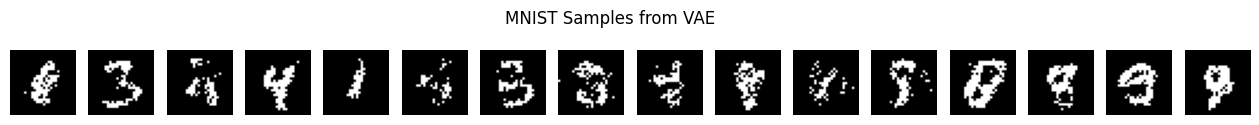

We didn't define a big enough VAE model nor train long enough to get clear digits back, but hopefully you can see that they are a fuzzy version of the MNIST digits we visualized above.  Feel free to train longer or use a bigger model to try to improve the results, but it's not necessary.


In [9]:
# -----------------------------
# Show Samples from VAE
# -----------------------------
n_samples = 16

# make sure the model is in evalution mode
vae.eval()

### YOUR SOLUTION GOES HERE ### (1 Point)
samples = ???
###############################

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples, 1.5))
for i in range(n_samples):
    axes[i].imshow(samples[i, 0], cmap='gray')
    axes[i].axis('off')

plt.suptitle("MNIST Samples from VAE")
plt.show()

SyntaxError: invalid syntax (<ipython-input-9-9a92d8cfa56f>, line 10)

## Uploading your Solution

Turn in your solution via Gradescope (accessed through Canvas).  You need to upload *two* files to two different assignment pages within Gradescope:
*   a PDF of your code and solutions as shown in the notebook.  You can generate it via File > Print > Save as PDF.  Make sure all of your code and plotting cells are visible.
*   a Python file (file.py).  You can export one from the notebook via File > Download > Download .py.